In [1]:
%matplotlib inline 
import fusim16.Ising as ising
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import copy
import fusim16

# Grundlagen



\begin{align}
\text{Spin} \quad s_i^z &= \pm 1 \\
\text{Energie} \quad \hat{\mathcal H}  &= -\frac{1}{2}\sum _{ij} J_{ij} s_i^z s_j^z - H_z \sum_{i=1}^N s_i^z \quad \\ \text{mit Kopplungskonstante } J_{ij} &= 1, \text{Magnetfeld } H_z = 0 \\
\hat{\mathcal H} &= -\frac{1}{2}\sum _{ij} s_i^z s_j^z
\end{align}

# Struktur

```python
print dir(fusim16)
print dir(fusim16.Ising)
print dir(fusim16.Ising.System)
print dir(fusim16.Ising.System.Metropolis)

['Cluster', 'Ising', 'PCA']
['Plot', 'System']
['Init', 'Measure', 'Metropolis', 'Wolff']
['fromBitFile', 'fromFile', 'getBeta', 'getEnergy', 'getJ', 'getMag', 'getSize', 'getTemp', 'makeConfig', 'oneMeasureStep', 'oneStep', 'randXY', 'run', 'runPartial', 'toBitFile', 'toFile']
```

# Implementierung

## C Funktionen

```c
int  _getEnergy(int* config, int m);    
void _oneMetropolisStep(int* config, double* delta, double beta, int m, int acstep);
void _oneMetropolisStepWithMeasurement(int* config, double* delta, double beta, int m, int acstep, double* E1, double* E2, double* M1, double* M2);
void _runMetropolis(int* config, double* delta, int m, double beta, int steps);
```

```c
int _getEnergy(int* config, int m){
    int x, y, energy;
    energy = 0;
    for (x=0; x<m; x++){
        for (y=0; y<m; y++){
            energy -= _getLocalEnergy(config, x, y, m);
        }
    }
    return energy/2;
}
```

```c
int _getLocalEnergy(int* config, int x, int y, int m) {
    return config[x*m+y]*(config[_bc(x+1,m)*m+y]+config[_bc(x-1,m)*m+y]+config[x*m+_bc(y+1,m)]+config[x*m+_bc(y-1,m)]);
}
```

```c
void _oneMetropolisStep(int* config, double* delta, double beta, int m, int acstep){
    int x        = _randomInt(m);
    int y        = _randomInt(m);
    double pflip = _random();
    int dE       = 2*_getLocalEnergy(config, x, y, m);
    if (dE <= 0 || pflip < _fastPow(M_E,-beta*dE)){
        config[x*m+y] *= -1;
        delta[acstep*2] = x;
        delta[acstep*2+1] = y;
}
```

```c
double _fastPow(double a, double b) {
    union {
        double d;
        int x[2];
    } u = { a };
    u.x[1] = (int)(b * (u.x[1] - 1072632447) + 1072632447);
    u.x[0] = 0;
    return u.d;
}
```


|beta\dE|  -4     |    -3   |     -2  |     -1  |     0   |      1  |      2  |     3   |      4  |
|   :-: |   :-:   |   :-:   |   :-:   |   :-:   |   :-:   |   :-:   |   :-:   |   :-:   |   :-:   |
|   1   | **0.943**| 0.950| 0.961| 1.000| 0.971| 1.036| 1.023| 1.061|**1.086**|
|   2   | 0.961| 0.952| 1.000| 1.001| 0.971| 1.016| 1.036| 1.017| 1.023|
|   3   | 0.965| 1.000| 0.968| 1.013| 0.971| 1.025| 0.972| 1.036| 0.998|
|   4   | 1.000| 0.949| 1.001| 1.009| 0.971| 1.019| 1.016| 0.994| 1.036|

```
Max abweichung durch fastpower() = 8.6432%
Mean = 0.998997
```

In [ ]:
[('beta/dE',  '-4',     '-3',     '-2',     '-1',     '0',      '1',      '2',      '3',      '4'),
(  '1',     0.943923, 0.950646, 0.961565, 1.000000, 0.971008, 1.036271, 1.023168, 1.061170, 1.086432),
(  '2',     0.961565, 0.952946, 1.000000, 1.001126, 0.971008, 1.016810, 1.036271, 1.017527, 1.023168),
(  '3',     0.965564, 1.000000, 0.968697, 1.013455, 0.971008, 1.025524, 0.972536, 1.036271, 0.998224),
(  '4',     1.000000, 0.949324, 1.001126, 1.009556, 0.971008, 1.019346, 1.016810, 0.994551, 1.036271)]

Max abweichung durch fastpower() = 8.6432%
Mean = 0.998997

## Simulation

```python
class Init:
    
    def makeConfig(self):
        
        self.initial_config = __np__.random.random_integers(0,1,(self.size,self.size))*2 - 1
        self.initial_config = self.initial_config.astype(__np__.int32)

        return self.initial_config
     
    def getEnergy(self, config):
    
        energy = __cSystem__.getEnergy(config)
        
        return  energy
```

```python
class Metropolis(Init):

    def run(self, steps):
        self.delta = __np__.zeros((steps,2))-1
        starttime = __time__.time()
        __cSystem__.runMetropolis(self.config, self.delta, self.size, self.beta, steps)
        return self.initialConfig, self.delta
```

```python
def sim(N,S,T): # Gitterlänge, Anzahl der Schritte, Temperatur
    system = ising.System.Metropolis(N, T)
    initialConfig, configChanges = system.run(S)
```

```python
    plots = []
    k = 1
    f = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k'); 
    
    for i, site in enumerate(configChanges):
        if site[0] != -1:
            initialConfig[site[0]][site[1]] *= -1
            
        if i%int(len(configChanges)/5) == 0 or i == int(N*N*2) or i == int(N*N*4) or i == int(N*N*8) or i == len(configChanges)-1:
            plots.append(copy.deepcopy(initialConfig))
            f.add_subplot(3, 3, k);
            plt.imshow(plots[k-1], interpolation="nearest")
            plt.title('Step '+str(i))
            k += 1

    plt.show()
    return initialConfig, configChanges
```

In [11]:
def sim(N,S,T):
    system = ising.System.Metropolis(N, T)
    initialConfig, configChanges = system.run(S)

    plots = []
    k = 1
    f = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k'); 
    
    for i, site in enumerate(configChanges):
        if site[0] != -1:
            initialConfig[site[0]][site[1]] *= -1
            
        if i%int(len(configChanges)/5) == 0 or i == int(N*N*2) or i == int(N*N*4) or i == int(N*N*8) or i == len(configChanges)-1:
            plots.append(copy.deepcopy(initialConfig))
            f.add_subplot(3, 3, k);
            plt.imshow(plots[k-1], interpolation="nearest")
            plt.title('Step '+str(i))
            k += 1

    plt.show()
    return initialConfig, configChanges
    
# System kommt nach N*N*2 Schritten, also 2 kompletten updates des Gitters ins Gelichgewicht

c:\miniconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


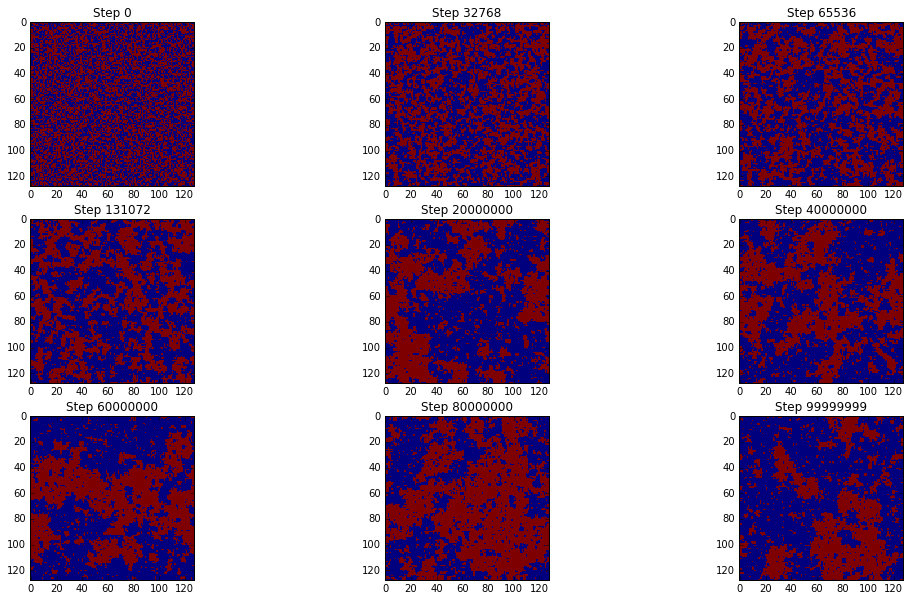

In [43]:
N = 128
S = 100000000
T = 2.26
sim(N,S,T)
sim1init, sim1delta = copy.deepcopy(initialConfig), copy.deepcopy(configChanges)

c:\miniconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


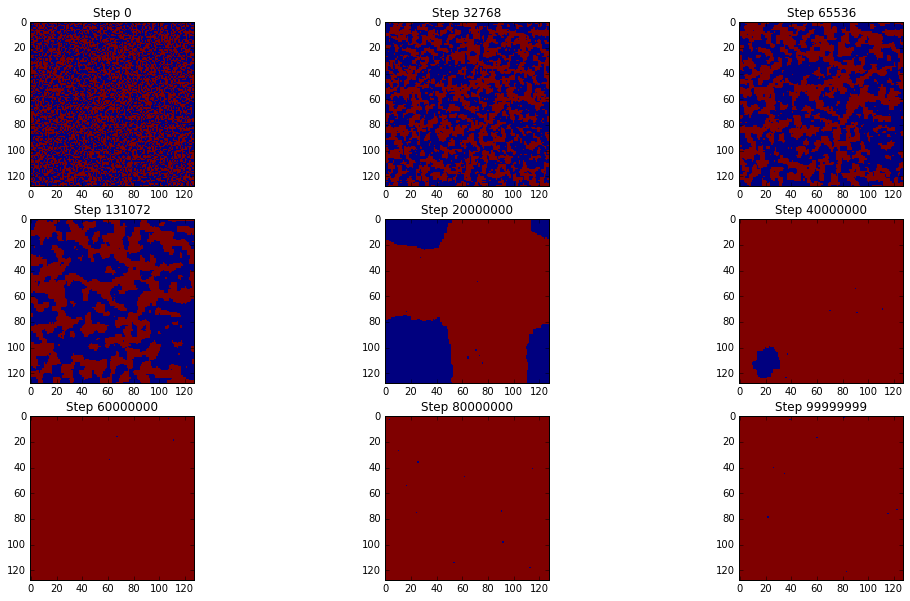

In [44]:
N = 256
S = 100000000
T = 1
sim(N,S,T)
sim2init, sim2delta = copy.deepcopy(initialConfig), copy.deepcopy(configChanges)

c:\miniconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


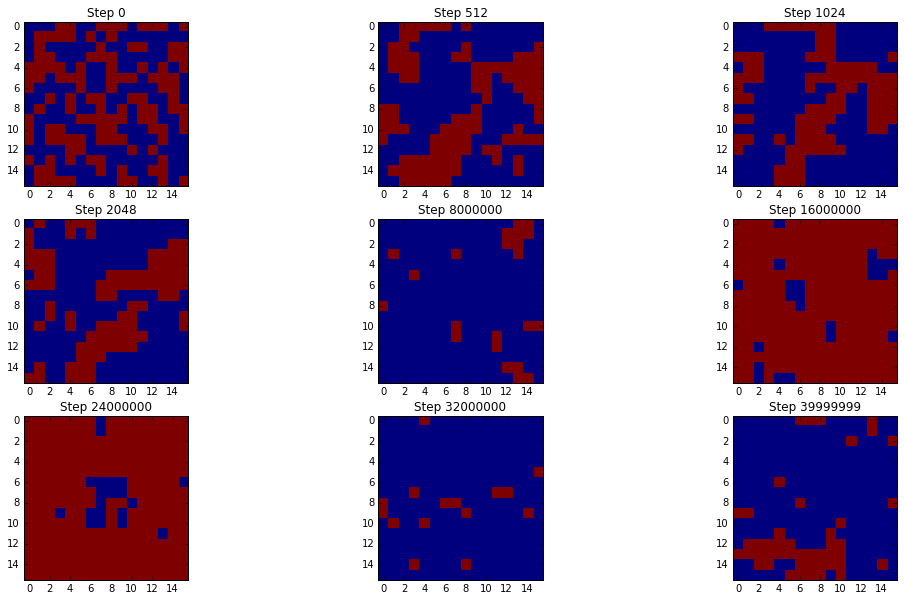

In [12]:
N = 16
S = 40000000
T = 2.15
sim3init, sim3delta = sim(N,S,T)

## I/O
```python
def toFile(self, filename, config, delta):
    fp = __np__.memmap(str(filename)+'_'+str(config.shape[0])+'_'+str(len(delta)+1)+'.npy', dtype='int32', mode='w+', shape=(config.shape[0]*(len(delta)+1),config.shape[0]))        
    fp[0:config.shape[0]] = config
    for i, site in enumerate(delta):
        if site[0] != -1:
            config[site[0]][site[1]] *= -1
        fp[(i+1)*(config.shape[0]):(i+2)*(config.shape[0])] = config
    del fp
            
def fromFile(self, filename):
    n = int(filename.split('_')[1])
    steps = int(filename.split('_')[2].split('.')[0])
    fpr = __np__.memmap(filename, dtype='int32', mode='c', shape=(n*steps,n))
    return fpr
```

## Messungen/Unittests


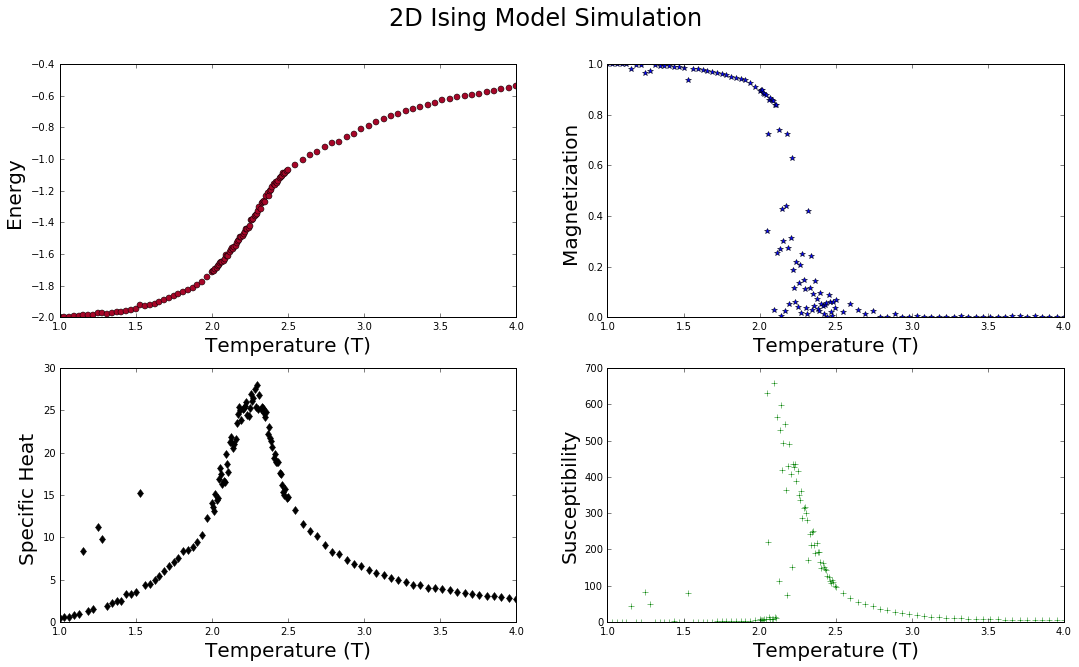

In [5]:
%matplotlib inline
init = ising.System.Measure(16,128,30000)
plt = ising.Plot.Graph()
T, Energy, Magnetization, SpecificHeat, Susceptibility = init.measureSystem()
plt.printGraphs(T, Energy, Magnetization, SpecificHeat, Susceptibility)

```python
def test_energy_function(self):
    metropolis=lib.Metropolis(32,50)
    self.assertTrue(metropolis.getEnergy(np.ones((32,32)).astype(np.int32))==-1*2*32*32*metropolis.getJ())
    
def test_distribution(self):
      cmeasure = lib.Measure(8,128,8000)
      T, Energy, Magnetization, SpecificHeat, Susceptibility = cmeasure.measureSystem()
      
      # Checks right slope of Susceptibility
      data = zip(T,Energy)
      data = [x for x in data if x[0]>2.3]      
      data = [x for x in data if x[0]<3]
      xCr = zip(*data)[0]
      yCr = np.array(zip(*data)[1])
      zCr = np.array([(7576/x**6) for x in xCr])
      dMr = yCr/zCr

      [self.assertTrue(False) for x in dMr if 1.12 < x < 0.88]
```

### Pentium 3.2 GHz Dual Core

| Gitter initialisieren | Simulation 1.000.000 Schritte |   
|   :-:                |   :-:                         |  
|   ~1 ms               |           ~110 ms              | 


In [14]:
%matplotlib qt
show = ising.Plot.Show(sim3init, sim3delta, [])
show.saveVideo()

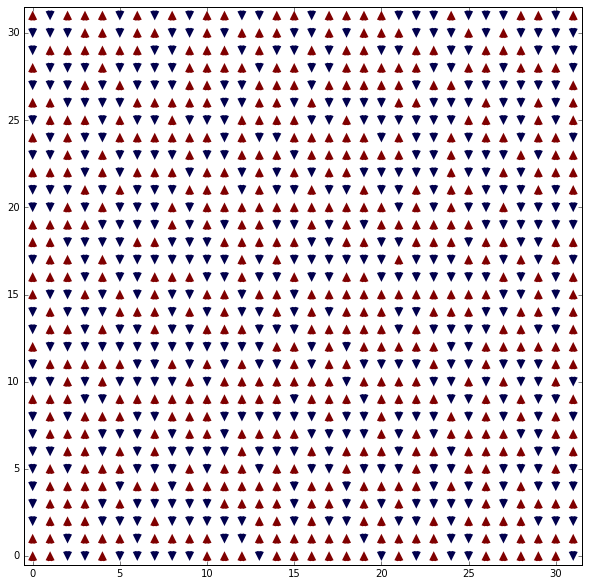

In [24]:
N = 32
S = 1
T = 1
system = ising.System.Metropolis(N, T)
initialConfig, configChanges = system.run(S)

n = initialConfig.shape[0]
x = np.linspace(0,n-1,n)
y = np.linspace(n-1,0,n)
(X,Y) = np.meshgrid(x,y)

plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k'); 


u = 0
v = initialConfig
q = plt.quiver(X,Y,u,v,initialConfig,                   # colour the arrows based on this array
           cmap=cm.seismic,     # colour map
           headlength=4, headwidth=4, width=0.004, pivot='mid')
plt.axis([-0.5, n-0.5, -0.5, n-0.5])

#plt.grid(linestyle='-', linewidth=1.5,rasterized=True)

plt.show()